# DuckDB Python Client Basics
Author: Mark Bauer

This guide is based on the DuckDB documentation here: https://duckdb.org/docs/api/python/overview.  

To install the DuckdDB Python API, refer to the docs above.

In [37]:
import duckdb
import pandas as pd
import numpy as np
import polars as pl
import pyarrow as pa

print(f"duckdb version: {duckdb.__version__}")

duckdb version: 1.0.0


# Table of Contents
1. Basic Python API Usage
2. Data Input
3. DataFrames
4. Result Conversion
5. Writing Data to Disk
6. Connection Options  
    - 6.1 Using an In-Memory Database  
    - 6.2 Persistent Storage
7. Loading and Installing Extensions   
8. Jupyter Notebooks and Querying Pandas Dataframes

# 1. Basic Python API Usage

In [38]:
duckdb.sql("SELECT 1, 2.0, 'a', 'TRUE'")

┌───────┬──────────────┬─────────┬─────────┐
│   1   │     2.0      │   'a'   │ 'TRUE'  │
│ int32 │ decimal(2,1) │ varchar │ varchar │
├───────┼──────────────┼─────────┼─────────┤
│     1 │          2.0 │ a       │ TRUE    │
└───────┴──────────────┴─────────┴─────────┘

In [39]:
type(duckdb.sql("SELECT 1, 2.0, 'a', 'TRUE'"))

duckdb.duckdb.DuckDBPyRelation

In [40]:
# you can also use .show() to preview the relation
duckdb.sql("SELECT 1, 2.0, 'a', 'TRUE'").show()

┌───────┬──────────────┬─────────┬─────────┐
│   1   │     2.0      │   'a'   │ 'TRUE'  │
│ int32 │ decimal(2,1) │ varchar │ varchar │
├───────┼──────────────┼─────────┼─────────┤
│     1 │          2.0 │ a       │ TRUE    │
└───────┴──────────────┴─────────┴─────────┘



In [41]:
# assign relation
relation = duckdb.sql("SELECT 10 AS i")

# query relation
(duckdb
 .sql("SELECT i * 2 AS k FROM relation")
 .show()
)

┌───────┐
│   k   │
│ int32 │
├───────┤
│    20 │
└───────┘



# 2. Data Input
We will focus on reading CSVs for now. Below are various ways to read in CSV files.

In [42]:
# reading in a CSV with the duckdb.read_csv() function
path = "data/green_infrastructure.csv"

duckdb.read_csv(path)

┌──────────────────────┬──────────┬──────────┬────────────┬───┬────────────┬────────────────────┬─────────────────┐
│       the_geom       │ Asset_ID │  GI_ID   │ DEP_Contra │ … │ Construc_1 │     Program_Ar     │   Status_Gro    │
│       varchar        │  int64   │ varchar  │  varchar   │   │  varchar   │      varchar       │     varchar     │
├──────────────────────┼──────────┼──────────┼────────────┼───┼────────────┼────────────────────┼─────────────────┤
│ POINT (-73.8116762…  │    94002 │ 1A       │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8122857…  │    94012 │ GS6A     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8122344…  │    94017 │ GS8C     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8120597…  │    94019 │ GS8E     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8131019…  │    94021 │ 10A      │ GQJA03-02  │ … │ Package-

In [43]:
# reading in a CSV via the duckdb.sql() method
duckdb.sql(
    """
    SELECT *
    FROM read_csv("data/green_infrastructure.csv")
    LIMIT 10
    """
)

┌──────────────────────┬──────────┬─────────┬────────────┬───┬────────────┬────────────────────┬─────────────┐
│       the_geom       │ Asset_ID │  GI_ID  │ DEP_Contra │ … │ Construc_1 │     Program_Ar     │ Status_Gro  │
│       varchar        │  int64   │ varchar │  varchar   │   │  varchar   │      varchar       │   varchar   │
├──────────────────────┼──────────┼─────────┼────────────┼───┼────────────┼────────────────────┼─────────────┤
│ POINT (-73.8116762…  │    94002 │ 1A      │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8122857…  │    94012 │ GS6A    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8122344…  │    94017 │ GS8C    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8120597…  │    94019 │ GS8E    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8131019…  │    94021 │ 10A     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│

In [44]:
# reading in a CSV by opening a connection and copying data to a table
con = duckdb.connect()

con.sql(
    """
    CREATE TABLE green_infrastructure
    AS FROM read_csv('data/green_infrastructure.csv')
    """
)

con.sql(
    """
    SELECT *
    FROM green_infrastructure
    """
)

┌──────────────────────┬──────────┬──────────┬────────────┬───┬────────────┬────────────────────┬─────────────────┐
│       the_geom       │ Asset_ID │  GI_ID   │ DEP_Contra │ … │ Construc_1 │     Program_Ar     │   Status_Gro    │
│       varchar        │  int64   │ varchar  │  varchar   │   │  varchar   │      varchar       │     varchar     │
├──────────────────────┼──────────┼──────────┼────────────┼───┼────────────┼────────────────────┼─────────────────┤
│ POINT (-73.8116762…  │    94002 │ 1A       │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8122857…  │    94012 │ GS6A     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8122344…  │    94017 │ GS8C     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8120597…  │    94019 │ GS8E     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed     │
│ POINT (-73.8131019…  │    94021 │ 10A      │ GQJA03-02  │ … │ Package-

# 3. DataFrames

In [45]:
# pandas
df = pd.DataFrame({"numbers": [1, 2, 3, 4]})

duckdb.sql("SELECT * FROM df")

┌─────────┐
│ numbers │
│  int64  │
├─────────┤
│       1 │
│       2 │
│       3 │
│       4 │
└─────────┘

In [46]:
# polars
df = pl.DataFrame({"numbers": [1, 2, 3, 4]})

duckdb.sql("SELECT * FROM df")

┌─────────┐
│ numbers │
│  int64  │
├─────────┤
│       1 │
│       2 │
│       3 │
│       4 │
└─────────┘

In [47]:
# pyarrow
df = pa.Table.from_pydict({"numbers": [1, 2, 3, 4]})

duckdb.sql("SELECT * FROM df")

┌─────────┐
│ numbers │
│  int64  │
├─────────┤
│       1 │
│       2 │
│       3 │
│       4 │
└─────────┘

# 4. Result Conversion

In [48]:
# Python objects
print(type(duckdb.sql("SELECT 1 as num").fetchall()))

# NumPy Arrays
print(type(duckdb.sql("SELECT 1 as num").fetchnumpy())) 

# Pandas DataFrame
print(type(duckdb.sql("SELECT 1 as num").df()))

# Polars DataFrame
print(type(duckdb.sql("SELECT 1 as num").pl()))

# Arrow Table
print(type(duckdb.sql("SELECT 1 as num").arrow()))

<class 'list'>
<class 'dict'>
<class 'pandas.core.frame.DataFrame'>
<class 'polars.internals.dataframe.frame.DataFrame'>
<class 'pyarrow.lib.Table'>


In [49]:
# Example: pandas DataFrame
duckdb.sql("SELECT 1 as num").df()

,num
0,1


In [50]:
type(duckdb.sql("SELECT 1 as num").df())

pandas.core.frame.DataFrame

# 5. Writing Data to Disk

In [51]:
# Write to a CSV file
duckdb.sql("SELECT 100").write_csv("data/out.csv") 

# Write to a Parquet file
duckdb.sql("SELECT 100").write_parquet("data/out.parquet") 

# Copy to a Parquet file
duckdb.sql("COPY (SELECT 100) TO 'data/out.parquet'")      

In [52]:
ls data/

data-dictionary.xlsx      out.csv
green_infrastructure.csv  out.parquet


# 6. Connection Options

## 6.1 Using an In-Memory Database

In [53]:
# create a DuckDB database instance
con = duckdb.connect()

type(con)

duckdb.duckdb.DuckDBPyConnection

In [54]:
(con
 .sql("SELECT 1 AS num, 'a' AS letter")
 .show()
)

┌───────┬─────────┐
│  num  │ letter  │
│ int32 │ varchar │
├───────┼─────────┤
│     1 │ a       │
└───────┴─────────┘



## 6.2 Persistent Storage

A connection to a persistent database can be created using the `connect` function.

In [55]:
con = duckdb.connect("data/file.db")

con.sql("CREATE TABLE IF NOT EXISTS integers (i INTEGER)")
con.sql("INSERT INTO integers VALUES (1), (2)")

con.sql("SELECT * FROM integers").show()

┌───────┐
│   i   │
│ int32 │
├───────┤
│     1 │
│     2 │
└───────┘



In [56]:
# reload the same file.db
con = duckdb.connect("data/file.db")

con.sql("SELECT * FROM integers").show()

┌───────┐
│   i   │
│ int32 │
├───────┤
│     1 │
│     2 │
└───────┘



In [57]:
# create a connection to a file called 'file.db'
con = duckdb.connect("data/file.db")

# insert new values to file.db
con.sql("INSERT INTO integers VALUES (3)")

# query the table
con.table("integers").show()

# explicitly close the connection
con.close()
# Note: connections also closed implicitly when they go out of scope

┌───────┐
│   i   │
│ int32 │
├───────┤
│     1 │
│     2 │
│     3 │
└───────┘



In [58]:
# use a context manager to ensure connection is closed
with duckdb.connect("data/file.db") as con:
    con.sql("INSERT INTO integers VALUES (4)")
    con.table("integers").show()
    # the context manager closes the connection automatically

┌───────┐
│   i   │
│ int32 │
├───────┤
│     1 │
│     2 │
│     3 │
│     4 │
└───────┘



# 7. Loading and Installing Extensions
Overview of extensions: https://duckdb.org/docs/extensions/overview

In [59]:
con = duckdb.connect()
con.install_extension("spatial")
con.load_extension("spatial")

con.sql(
    """
    CREATE TABLE green_infrastructure
    AS FROM read_csv('data/green_infrastructure.csv')
    """
)

con.sql(
    """
    SELECT *
    FROM green_infrastructure LIMIT 5
    """
)

┌──────────────────────┬──────────┬─────────┬────────────┬───┬────────────┬────────────────────┬─────────────┐
│       the_geom       │ Asset_ID │  GI_ID  │ DEP_Contra │ … │ Construc_1 │     Program_Ar     │ Status_Gro  │
│       varchar        │  int64   │ varchar │  varchar   │   │  varchar   │      varchar       │   varchar   │
├──────────────────────┼──────────┼─────────┼────────────┼───┼────────────┼────────────────────┼─────────────┤
│ POINT (-73.8116762…  │    94002 │ 1A      │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8122857…  │    94012 │ GS6A    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8122344…  │    94017 │ GS8C    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8120597…  │    94019 │ GS8E    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8131019…  │    94021 │ 10A     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
├

In [60]:
# convert string column to geometry type
con.sql(
    """
    SELECT the_geom, ST_GeomFromText(the_geom)
    FROM green_infrastructure LIMIT 5
    """
)

┌──────────────────────────────────────────────┬──────────────────────────────────────────────┐
│                   the_geom                   │          st_geomfromtext(the_geom)           │
│                   varchar                    │                   geometry                   │
├──────────────────────────────────────────────┼──────────────────────────────────────────────┤
│ POINT (-73.81167623024226 40.69138622900597) │ POINT (-73.81167623024226 40.69138622900597) │
│ POINT (-73.81228577606385 40.69238458134393) │ POINT (-73.81228577606385 40.69238458134393) │
│ POINT (-73.8122344420821 40.69312522070409)  │ POINT (-73.8122344420821 40.69312522070409)  │
│ POINT (-73.8120597400255 40.6931738947353)   │ POINT (-73.8120597400255 40.6931738947353)   │
│ POINT (-73.81310191327061 40.69279332424906) │ POINT (-73.81310191327061 40.69279332424906) │
└──────────────────────────────────────────────┴──────────────────────────────────────────────┘

In [61]:
con.close()

# 8. Jupyter Notebooks and Querying Pandas Dataframes

In [62]:
%reload_ext sql
conn = duckdb.connect(config={"allow_unsigned_extensions": "true"})
%sql conn --alias duckdb

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [63]:
%sql res << SELECT 'a' AS letter;

print(type(res))
res

<class 'pandas.core.frame.DataFrame'>


,letter
0,a


In [64]:
dct = {
    "i": [1, 2, 3],
    "j": ["one", "two", "three"]
}

input_df = pd.DataFrame.from_dict(dct)

input_df

,i,j
0,1,one
1,2,two
2,3,three


In [65]:
%%sql output_df <<
SELECT sum(i)AS total_i
FROM input_df;

In [66]:
output_df

,total_i
0,6.0


In [67]:
%%sql
SELECT *
FROM "data/green_infrastructure.csv"
LIMIT 5;

,the_geom,Asset_ID,GI_ID,DEP_Contra,DEP_Cont_1,Row_Onsite,Project_Na,Asset_Type,Status,Asset_X_Co,...,Asset_Leng,Asset_Widt,Asset_Area,GI_Feature,Tree_Latin,Tree_Commo,Constructi,Construc_1,Program_Ar,Status_Gro
0,POINT (-73.81167623024226 40.69138622900597),94002,1A,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWB,Constructed (Full Maintenance),1.036475e+06,...,17.0,5.0,85.0,Standard,Chionanthus retusus,Chinese Fringetree,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
1,POINT (-73.81228577606385 40.69238458134393),94012,GS6A,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWGS,Constructed (Full Maintenance),1.036305e+06,...,13.0,3.5,45.5,None,No Tree,N/A,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
2,POINT (-73.8122344420821 40.69312522070409),94017,GS8C,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWGS,Constructed (Full Maintenance),1.036319e+06,...,20.0,3.5,70.0,None,No Tree,N/A,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
3,POINT (-73.8120597400255 40.6931738947353),94019,GS8E,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWGS,Constructed (Full Maintenance),1.036368e+06,...,20.0,3.5,70.0,None,No Tree,N/A,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
4,POINT (-73.81310191327061 40.69279332424906),94021,10A,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWB,Constructed (Full Maintenance),1.036079e+06,...,13.0,4.0,52.0,Standard,Quercus palustris,Pin Oak,GCJA03-2A,Package-1,Right of Way (ROW),Constructed


In [68]:
%%sql
SELECT COUNT(*) AS count
FROM "data/green_infrastructure.csv";

,count
0,14346


In [69]:
%%sql
SELECT *
FROM "data/green_infrastructure.csv"
WHERE Asset_Area > 100000;

,the_geom,Asset_ID,GI_ID,DEP_Contra,DEP_Cont_1,Row_Onsite,Project_Na,Asset_Type,Status,Asset_X_Co,...,Asset_Leng,Asset_Widt,Asset_Area,GI_Feature,Tree_Latin,Tree_Commo,Constructi,Construc_1,Program_Ar,Status_Gro
0,POINT (-74.00229569924448 40.757951817712886),138087,JCGR-1,PRIVATE_GR,OA,Onsite,Javits Center Green Roof,Green Roof,Constructed,9.836140e+05,...,0.0,0.0,435000.00,None,None,None,None,None,External,Constructed
1,POINT (-73.97540677936354 40.68267969192586),184036,BRCL_1,EXTGR-1,1,Onsite,620 Atlantic Avenue,Green Roof,Constructed,9.910710e+05,...,0.0,0.0,128158.78,None,None,None,None,None,External,Constructed
2,POINT (-73.97336608102242 40.72171423026087),187175,JohnVL-1,M144-214MA,1,Onsite,John V. Lindsay East River Park - Synthetic Tu...,Synthetic Turf Field Storage Layer,Constructed,9.916327e+05,...,0.0,0.0,102660.00,None,None,None,None,None,External,Constructed
3,POINT (-73.87308060078496 40.67026320022855),187191,B103-01STa,B103-116M,1,Onsite,Cypress Hills PG - Synthetic Turf Field Constr...,Synthetic Turf Field Storage Layer,Constructed,1.019458e+06,...,439.0,296.0,130383.00,None,None,None,None,None,External,Constructed
4,POINT (-73.90532182350593 40.72771532765737),187205,FrankP1,Q131-115M,1,Onsite,Frank Principe Park Ballfields Reconstruction,Synthetic Turf Field Storage Layer,Constructed,1.010492e+06,...,0.0,0.0,156052.00,None,None,None,None,None,External,Constructed
5,POINT (-73.91384618255019 40.66273858378287),187221,BetsyHead1,B008-318M,1,Onsite,"Betsy Head Park Synthetic Turf, Track, Sport C...",Synthetic Turf Field Storage Layer,Constructed,1.008152e+06,...,0.0,0.0,129244.00,None,None,None,None,None,External,Constructed
6,POINT (-74.19545588457119 40.561950486557514),187241,Freshkills1,RG-12450-506M,1,Onsite,Freshkills Park Owl Hollow Fields Construction,Synthetic Turf Field Storage Layer,Constructed,9.299417e+05,...,0.0,0.0,303481.00,None,None,None,None,None,External,Constructed
7,POINT (-74.10000722901887 40.58677303959207),187255,GenDM1,R067-117M,1,Onsite,Gen. Douglas MacArthur Park Ballfield and Bask...,Multiple GI Components,Constructed,9.564728e+05,...,0.0,0.0,117774.00,None,None,None,None,None,External,Constructed
8,POINT (-74.00553985329056 40.67329044837725),187266,SWPS21-113-D01,B126-116M,1,Onsite,Red Hook Recreation Area Remediation and Recon...,Synthetic Turf Field Storage Layer,Constructed,9.827133e+05,...,0.0,0.0,145471.00,None,None,None,None,None,External,Constructed
9,POINT (-73.73900323902018 40.732978292706164),189090,HILL-01MEDa,SEQ-MED-HW,1,ROW,Hillside Ave and Winchester Blvd,ROW Median,In Construction,1.056583e+06,...,1480.0,70.0,103600.00,None,None,None,None,None,Public Onsite,In Construction


In [70]:
%%sql --save green_infra --no-execute
SELECT *
FROM "data/green_infrastructure.csv";

Skipping execution...

<AxesSubplot: title={'center': "'Asset_Area' from 'green_infra'"}, ylabel='Asset_Area'>

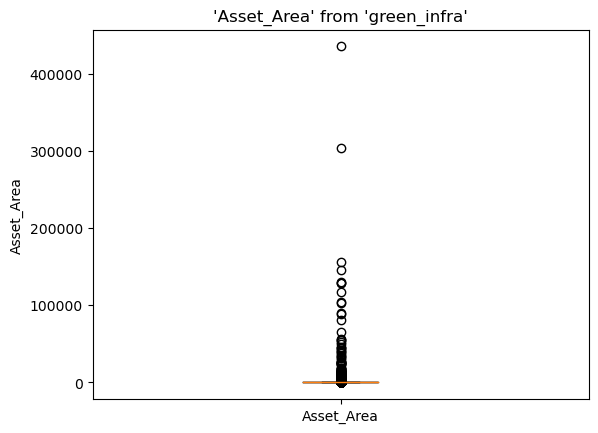

In [71]:
%sqlplot boxplot -t green_infra -c Asset_Area --with green_infra

<AxesSubplot: title={'center': "'Asset_Area' from 'green_infra'"}, xlabel='Asset_Area', ylabel='Count'>

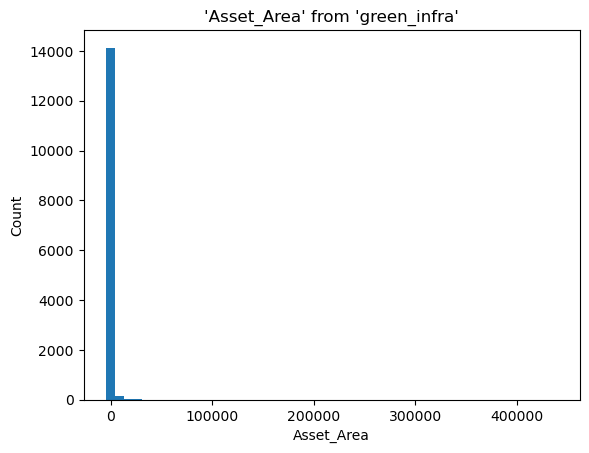

In [72]:
%sqlplot histogram -t green_infra -c Asset_Area --with green_infra